In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-07 17:43:12.822941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 17:43:12.823077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 17:43:12.935848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [6]:
base_model = tf.keras.applications.ConvNeXtLarge(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_large (Functional)     │ ?                      │   196,230,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,230,336 (748.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 196,230,336 (748.56 MB)

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - AUC: 0.1875 - Precision: 0.1250 - Recall: 0.1250 - accuracy: 0.1250 - loss: 1.0179                  

I0000 00:00:1715103923.526389     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715103923.576597     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715103923.577030     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715103923.577398     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - AUC: 0.7764 - Precision: 0.7037 - Recall: 0.7006 - accuracy: 0.6763 - loss: 0.6614

W0000 00:00:1715103935.014009     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715103935.014354     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715103935.014840     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76389, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 413ms/step - AUC: 0.7783 - Precision: 0.7054 - Recall: 0.7027 - accuracy: 0.6785 - loss: 0.6578 - val_AUC: 0.8672 - val_Precision: 0.7088 - val_Recall: 0.8958 - val_accuracy: 0.7639 - val_loss: 0.6622
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - AUC: 0.8641 - Precision: 0.7324 - Recall: 0.8691 - accuracy: 0.7911 - loss: 0.5539
Epoch 2: val_accuracy improved from 0.76389 to 0.78472, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - AUC: 0.8649 - Precision: 0.7330 - Recall: 0.8695 - accuracy: 0.7918 - loss: 0.5516 - val_AUC: 0.8954 - val_Precision: 0.7531 - val_Recall: 0.8472 - val_accuracy: 0.7847 - val_loss: 0.5971
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - AUC: 0.9412 - Precision: 0.8332 - Recall: 0.9262 - accuracy: 0.8776 - loss: 0.3498
Epoch 3: val_accuracy did not improve from 0.78472
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/s

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.80556
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - AUC: 0.9774 - Precision: 0.9332 - Recall: 0.9084 - accuracy: 0.9153 - loss: 0.2164 - val_AUC: 0.9259 - val_Precision: 0.7588 - val_Recall: 0.8958 - val_accuracy: 0.8056 - val_loss: 0.4519
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - AUC: 0.9599 - Precision: 0.9427 - Recall: 0.8274 - accuracy: 0.8738 - loss: 0.2766
Epoch 7: val_accuracy improved from 0.80556 to 0.87500, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - AUC: 0.9599 - Precision: 0.9418 - Recall: 0.8290 - accuracy: 0.8744 - loss: 0.2761 - val_AUC: 0.9440 - val_Precision: 0.9154 - val_Recall: 0.8264 - val_accuracy: 0.8750 - val_loss: 0.3367
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.9434 - Precision: 0.9785 - Recall: 0.8396 - accuracy: 0.9021 - loss: 0.3175
Epoch 8: val_accuracy did not improve from 0.87500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - AUC: 0.9434 - Precision: 0.978

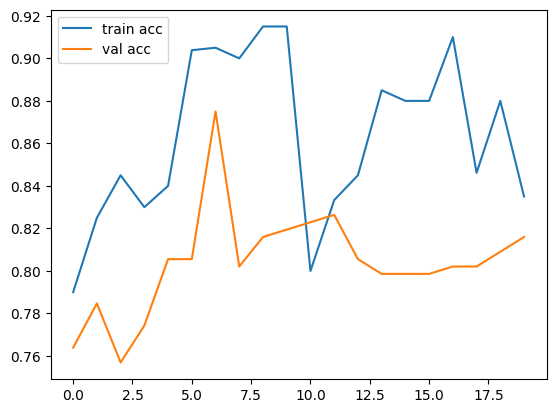

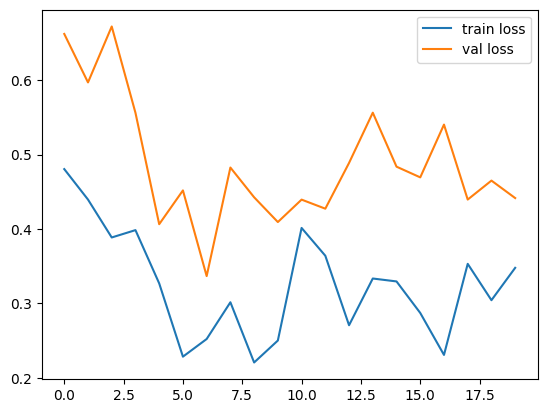

In [9]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('ConvNeXt-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('ConvNeXt-loss.png')
plt.show()


In [10]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - AUC: 0.9434 - Precision: 0.8823 - Recall: 0.8947 - accuracy: 0.8565 - loss: 0.3123


W0000 00:00:1715104161.015592     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104161.015973     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104161.016450     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.32738152146339417,
 0.9412697553634644,
 0.8609022498130798,
 0.908730149269104,
 0.8578199148178101]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


W0000 00:00:1715104179.700498     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104179.700952     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104179.701370     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104179.707464     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104179.707860     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104179.708250     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[[0.999311]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


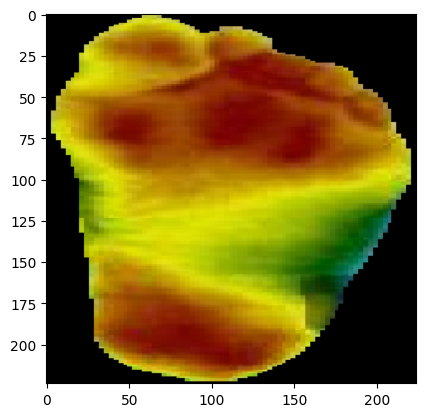

In [11]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.1886955]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


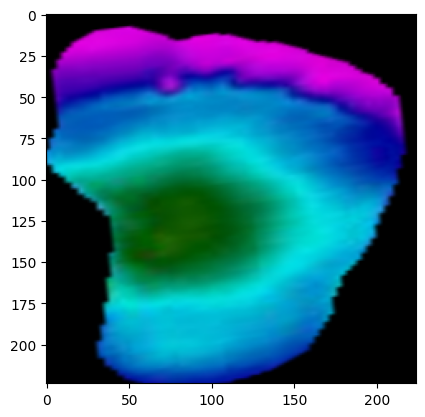

In [12]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/Control Group/CG001_M_L-rotated1-rotated1.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

In [13]:
import numpy as np
from sklearn.metrics import classification_report

In [14]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

  4/106 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step

W0000 00:00:1715104212.327866     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104212.328241     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104212.328690     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step


W0000 00:00:1715104224.590353     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104224.590699     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715104224.591177     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [15]:
report = classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices, zero_division=1)

In [16]:
print("Classification Report for Test Data:")
print(report)

Classification Report for Test Data:
               precision    recall  f1-score   support

Control Group       0.40      1.00      0.57       170
     DM Group       1.00      0.00      0.00       252

     accuracy                           0.40       422
    macro avg       0.70      0.50      0.29       422
 weighted avg       0.76      0.40      0.23       422

